In [1]:
import glob2
import os
PATH = "./dataset/raw_videos/raw_videos/"
video_list = glob2.glob(PATH + "*.avi")

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob2
from src.dataset import DatasetForVideo2
from src.utils.utility import preparing_video_dataset

root_dir = "./dataset/temp"
shot_list, _, _ = preparing_video_dataset(root_dir)
df_disrupt = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

data_dis1 = DatasetForVideo2(shot_list, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 1)
data_dis2 = DatasetForVideo2(shot_list, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 2)
data_dis3 = DatasetForVideo2(shot_list, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 3)
data_dis4 = DatasetForVideo2(shot_list, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 4)
data_dis5 = DatasetForVideo2(shot_list, df_disrupt, augmentation = True, augmentation_args=None, crop_size = 128, seq_len = 21, dist = 5)

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


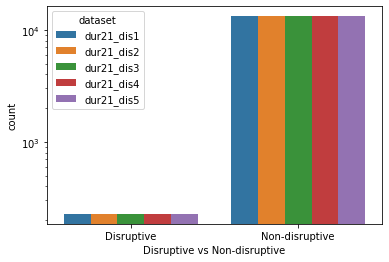

In [5]:
df = pd.DataFrame({
    "dataset":['dur21_dis1', 'dur21_dis2', 'dur21_dis3','dur21_dis4', 'dur21_dis5'] + ['dur21_dis1', 'dur21_dis2', 'dur21_dis3','dur21_dis4', 'dur21_dis5'],
    "count" : [data_dis1.n_disrupt, data_dis2.n_disrupt, data_dis3.n_disrupt, data_dis4.n_disrupt, data_dis5.n_disrupt] \
        + [data_dis1.n_normal, data_dis2.n_normal, data_dis3.n_normal, data_dis4.n_normal, data_dis5.n_normal],
    'label':['Disruptive'] * 5 + ['Non-disruptive'] * 5
})

g = sns.barplot(data = df, x = 'label', y = 'count', hue = 'dataset')
g.set_yscale("log")
_ = g.set(xlabel="Disruptive vs Non-disruptive", ylabel="count")

In [3]:
# consider tv01 and tv02.avi 
video_shot_list = []
for path in video_list:
    shot_num = path.split("/")[-1].split(".")[0][:-4]
    shot_num = int(shot_num)
    video_shot_list.append(shot_num)

import numpy as np
video_shot_list = np.unique(np.array(video_shot_list)).tolist()

print("total video number : ", len(video_shot_list))

total video number :  376


In [4]:
import pandas as pd
kstar_shot_df = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List.csv', encoding = "euc-kr")
kstar_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,Isdata
0,12350,2015,1.5,5.246,5.2248,NaN
1,12372,2015,0.7,3.818,3.8026,NaN
2,12415,2015,1.9,4.769,4.7450,NaN
3,12438,2015,1.1,3.702,3.6826,NaN
4,12481,2015,1.9,5.217,5.1923,NaN


In [5]:
year_list = []
tftsrt_list = []
tipminf_list = []
tTQend_list = []
dt_list = []
shot_list = []

for shot_num in video_shot_list:
    t_tqend = kstar_shot_df[kstar_shot_df.shot == shot_num]["tTQend"].values[0]
    t_ipmin = kstar_shot_df[kstar_shot_df.shot == shot_num]["tipminf"].values[0]
    t_ftsrt = kstar_shot_df[kstar_shot_df.shot == shot_num]["tftsrt"].values[0]
    year = kstar_shot_df[kstar_shot_df.shot == shot_num]["year"].values[0]
    dt = t_ipmin - t_tqend

    year_list.append(year)
    tftsrt_list.append(t_ftsrt)
    tipminf_list.append(t_ipmin)
    tTQend_list.append(t_tqend)
    dt_list.append(dt)
    shot_list.append(shot_num)

new_shot_df = pd.DataFrame(
    {
        "shot" : shot_list,
        "year" : year_list,
        "tftsrt" : tftsrt_list,
        "tipminf" : tipminf_list,
        "tTQend":tTQend_list,
        "dt" : dt_list
    }
)

new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,dt
0,18001,2017,0.90,8.519,8.4722,0.0468
1,18010,2017,0.89,3.738,3.6818,0.0562
2,18021,2017,1.10,3.329,3.2598,0.0692
3,18067,2017,0.90,6.890,6.8283,0.0617
4,18068,2017,0.90,7.012,6.9466,0.0654


In [6]:
# generate dataframe with frame_cutoff
# we assume that frame for current quench = frame for cut-off - 1 frame (almost 9ms)
# frame for current quench and thermal quech will be re-defined

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2, gc, warnings
from src.utils.utility import crop, normalize
from functools import partial
from tqdm.auto import tqdm
import numpy as np

warnings.filterwarnings("ignore")

save_dir = "./results/disruption_phase"
resize_height = 196
resize_width = 196
crop_size = 128
fps = 210
eps = 0.075

frame_cutoff_width = 210 * 0.25

new_shot_list = []
frame_startup_list = []
frame_cutoff_list = []
frame_thermal_quench_list = []
frame_current_quench_list = []

def check_startup(frame : np.ndarray, thres : float = eps):
    mean = np.mean(frame)
    if mean > thres:
        return True
    else:
        return False

def check_cutoff(frame : np.ndarray, thres : float = eps):
    mean = np.mean(frame)
    if mean < thres:
        return True
    else:
        return False

def norm(img : np.ndarray):
    img = img.astype(np.float32)
    img /= 255.
    return img

if not os.path.exists(save_dir):
    os.mkdir(os.path.join(save_dir))

for _, row in tqdm(new_shot_df.iterrows()):
    shot_num = row['shot']
    tTQend = row["tTQend"]
    tipminf = row["tipminf"]
    tftsrt = row['tftsrt']
    
    file_path = os.path.join(save_dir, "%06dtv01.png"%shot_num)
    video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

    if not os.path.exists(video_dir):
        file_path = os.path.join(save_dir, "%06dtv02.png"%shot_num)
        video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv02.avi"%shot_num)
        
    if not os.path.exists(video_dir):
            continue

    capture = cv2.VideoCapture(video_dir)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # filter : if frame_count is not comparative with the disruption log data, then ignore the shot
    frame_cutoff_estimate = int(tipminf * 210)
    
    if frame_count < frame_cutoff_estimate:
        continue
    
    count = 0
    channels = 3
    retaining = True

    buffer = np.empty((frame_count, resize_height, resize_width, channels), np.dtype('float32'))
    is_startup = False
    is_cutoff = False
    frame_startup = 0
    frame_cutoff = 0
    frame_srt = int(tftsrt * fps + 0.1 * fps)

    while (count < frame_count and retaining):
        retaining, frame = capture.read()
        
        if check_startup(frame, eps) and (is_startup is False):
            is_startup = True
            frame_startup = count

        if frame is None:
            frame = np.zeros((resize_width, resize_height, channels))

        if (frame_height != resize_height) or (frame_width != resize_width):
            frame = cv2.resize(frame, (resize_width, resize_height))

        if count > frame_srt and check_cutoff(norm(frame), eps) and not is_cutoff and count > frame_cutoff_estimate - frame_cutoff_width:
            frame_cutoff = count
            is_cutoff = True

        buffer[count] = frame
        count += 1

    capture.release()

    frame_current_quench = frame_cutoff - 1
    dt = row['dt']
    frame_thermal_quench = frame_current_quench - int(dt * fps)
    
    if frame_thermal_quench < 0 or frame_cutoff < 210:
        continue
    
    buffer = crop(buffer, resize_height, resize_width, crop_size)
    buffer = normalize(buffer)

    frame_interval = max(round((frame_cutoff - frame_thermal_quench + 2) / 8), 1)
    frame_indices = range(frame_thermal_quench - 1, frame_cutoff + 1, frame_interval)
    t_list = [tTQend - 1/fps + i / fps for i in range(len(frame_indices))]
    
    frame_startup = int((t_ftsrt + 0.1)* fps)

    frame_current_quench_list.append(frame_current_quench)
    frame_thermal_quench_list.append(frame_thermal_quench)
    frame_cutoff_list.append(frame_cutoff)
    frame_startup_list.append(frame_startup)
    new_shot_list.append(shot_num)

    # plot the image with (4 X N) array
    fig_width = 18
    fig_height = 0
    fig_cols = 4
    fig_rows = 2

    if len(frame_indices) % fig_cols > 0 and len(frame_indices) > fig_rows * fig_cols:
        fig_rows += 1

    fig_height = int(fig_rows * 4.5) + 4

    axes=[]
    fig = plt.figure(figsize = (fig_width, fig_height), facecolor = 'white')

    is_tq = False
    is_iq = False
    is_cutoff = False
    t_disrupt = 0

    for idx, frame_idx in enumerate(frame_indices):
        frame = buffer[frame_idx, :, :, :]
        t = t_list[idx]
        axes.append(fig.add_subplot(fig_rows, fig_cols, idx+1))

        if frame_idx == frame_thermal_quench:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), thermal quench"
        elif frame_idx == frame_current_quench:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), current quench"
        elif frame_idx >= frame_cutoff:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), disrupted"
        elif frame_idx > frame_thermal_quench and frame_idx < frame_current_quench:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), disruptive phase"
        else:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s)"
    
        axes[-1].set_title(subplot_title)  
        plt.imshow(frame)

    fig.tight_layout()    
    plt.savefig(file_path, facecolor = fig.get_facecolor(), edgecolor = 'none', transparent = False)
    plt.close()

    del buffer
    del capture
    del fig

    gc.collect()

0it [00:00, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [7]:
# revised shot log information
year_list = []
tftsrt_list = []
tipminf_list = []
tTQend_list = []
dt_list = []
shot_list = []

for shot_num in video_shot_list:
    t_tqend = kstar_shot_df[kstar_shot_df.shot == shot_num]["tTQend"].values[0]
    t_ipmin = kstar_shot_df[kstar_shot_df.shot == shot_num]["tipminf"].values[0]
    t_ftsrt = kstar_shot_df[kstar_shot_df.shot == shot_num]["tftsrt"].values[0]
    year = kstar_shot_df[kstar_shot_df.shot == shot_num]["year"].values[0]
    dt = t_ipmin - t_tqend
    
    if shot_num in new_shot_list:
        year_list.append(year)
        tftsrt_list.append(t_ftsrt)
        tipminf_list.append(t_ipmin)
        tTQend_list.append(t_tqend)
        dt_list.append(dt)
        shot_list.append(shot_num)

new_shot_df = pd.DataFrame(
    {
        "shot" : shot_list,
        "year" : year_list,
        "tftsrt" : tftsrt_list,
        "tipminf" : tipminf_list,
        "tTQend":tTQend_list,
        "dt" : dt_list,
        'frame_startup' : frame_startup_list,
        'frame_cutoff' : frame_cutoff_list,
        'frame_tTQend' : frame_thermal_quench_list,
        'frame_tipminf' : frame_current_quench_list
    }
)

new_shot_df.to_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv", index = False)

In [8]:
new_shot_df = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,dt,frame_startup,frame_cutoff,frame_tTQend,frame_tipminf
0,18001,2017,0.90,8.519,8.4722,0.0468,336,1776,1766,1775
1,18010,2017,0.89,3.738,3.6818,0.0562,336,786,774,785
2,18021,2017,1.10,3.329,3.2598,0.0692,336,699,684,698
3,18068,2017,0.90,7.012,6.9466,0.0654,336,1460,1446,1459
4,18156,2017,0.90,8.212,8.1420,0.0700,336,1705,1690,1704


In [25]:
error_shot_list = new_shot_df[new_shot_df['frame_startup'] > new_shot_df['frame_tTQend']].shot
new_shot_df[new_shot_df['frame_startup'] > new_shot_df['frame_tTQend']]

,shot,year,tftsrt,tipminf,tTQend,dt,frame_startup,frame_cutoff,frame_tTQend,frame_tipminf


In [13]:
4.888 * 210

1026.48

In [8]:
print("total shot : {}".format(len(new_shot_df.shot)))
print("unmatching error : {}".format(len(new_shot_df[new_shot_df['frame_startup'] > new_shot_df['frame_tTQend']])))

total shot : 364
unmatching error : 30


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


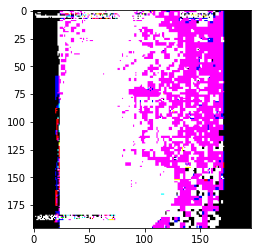

In [202]:
shot_num = 21274

file_path = os.path.join(save_dir, "%06dtv01.png"%shot_num)
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

if not os.path.exists(video_dir):
    file_path = os.path.join(save_dir, "%06dtv02.png"%shot_num)
    video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv02.avi"%shot_num)

capture = cv2.VideoCapture(video_dir)
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

count = 0
channels = 3
retaining = True

buffer = np.empty((frame_count, resize_height, resize_width, channels), np.dtype('float32'))
is_cutoff = False
frame_cutoff = 0
frame_srt = int(tftsrt * fps + 0.1 * fps)

while (count < frame_count and retaining):
    retaining, frame = capture.read()

    if frame is None:
        frame = np.zeros((resize_width, resize_height, channels))

    if (frame_height != resize_height) or (frame_width != resize_width):
        frame = cv2.resize(frame, (resize_width, resize_height))

    buffer[count] = frame
    count += 1

capture.release()

frame_cutoff = new_shot_df[new_shot_df.shot == shot_num]['frame_cutoff'].values.item()
frame = buffer[frame_cutoff]

plt.imshow(frame)
del capture

In [203]:
new_shot_df[new_shot_df.shot == shot_num]

,shot,year,tftsrt,tipminf,tTQend,dt,frame_cutoff,frame_tTQend,frame_tipminf
1,21274,2018,2.996,10.056,10.038,0.018,2104,2100,2103


mean :  0.34399065
ratio :  67.53618284048314


False

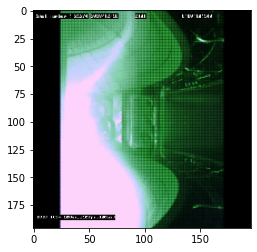

In [210]:
def check_cutoff(frame : np.ndarray, thres : float = eps):
    mean = np.mean(frame)
    total_pixel = frame.shape[0] * frame.shape[1] * frame.shape[2]
    ratio = np.sum(np.where(frame > mean)) / total_pixel

    print("mean : ", mean)
    print("ratio : ", ratio)

    if mean < thres * 255:
        return True
    elif ratio < eps:
        return True
    else:
        return False

def norm(img : np.ndarray):
    # img -= np.array([[[90.0, 98.0, 102.0]]])
    img /= 255.
    return img

frame = buffer[2100]
frame_norm = norm(frame)

plt.imshow(frame_norm)
check_cutoff(frame_norm, 1e-3)

frame_cutoff : image sequence with disrupted plasma
frame_tTQend : image sequence with thermal quench 
frame_tipminf : image sequence with current quench (define as frame_cutoff - 1)

In [6]:
s_shot_list = []
m_shot_list = []
l_shot_list = []

ts = 5.0
tm = 16.0

for shot in video_shot_list:
    tTQend = kstar_shot_df[kstar_shot_df.shot == shot]['tTQend'].values[0]
    if tTQend < ts:
        s_shot_list.append(shot)
    elif tTQend < tm:
        m_shot_list.append(shot)
    else:
        l_shot_list.append(shot)

print("shot with t_remain < {} : {}".format(ts, len(s_shot_list)))
print("shot with t_remain < {} : {}".format(tm, len(m_shot_list)))
print("shot with t_remain > {} : {}".format(tm, len(l_shot_list)))

shot with t_remain < 5.0 : 14
shot with t_remain < 16.0 : 61
shot with t_remain > 16.0 : 7


In [7]:
kstar_shot_df[kstar_shot_df.shot == 21274]

,shot,year,tftsrt,tipminf,tTQend,Isdata
1015,21274,2018,2.996,10.056,10.038,NaN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

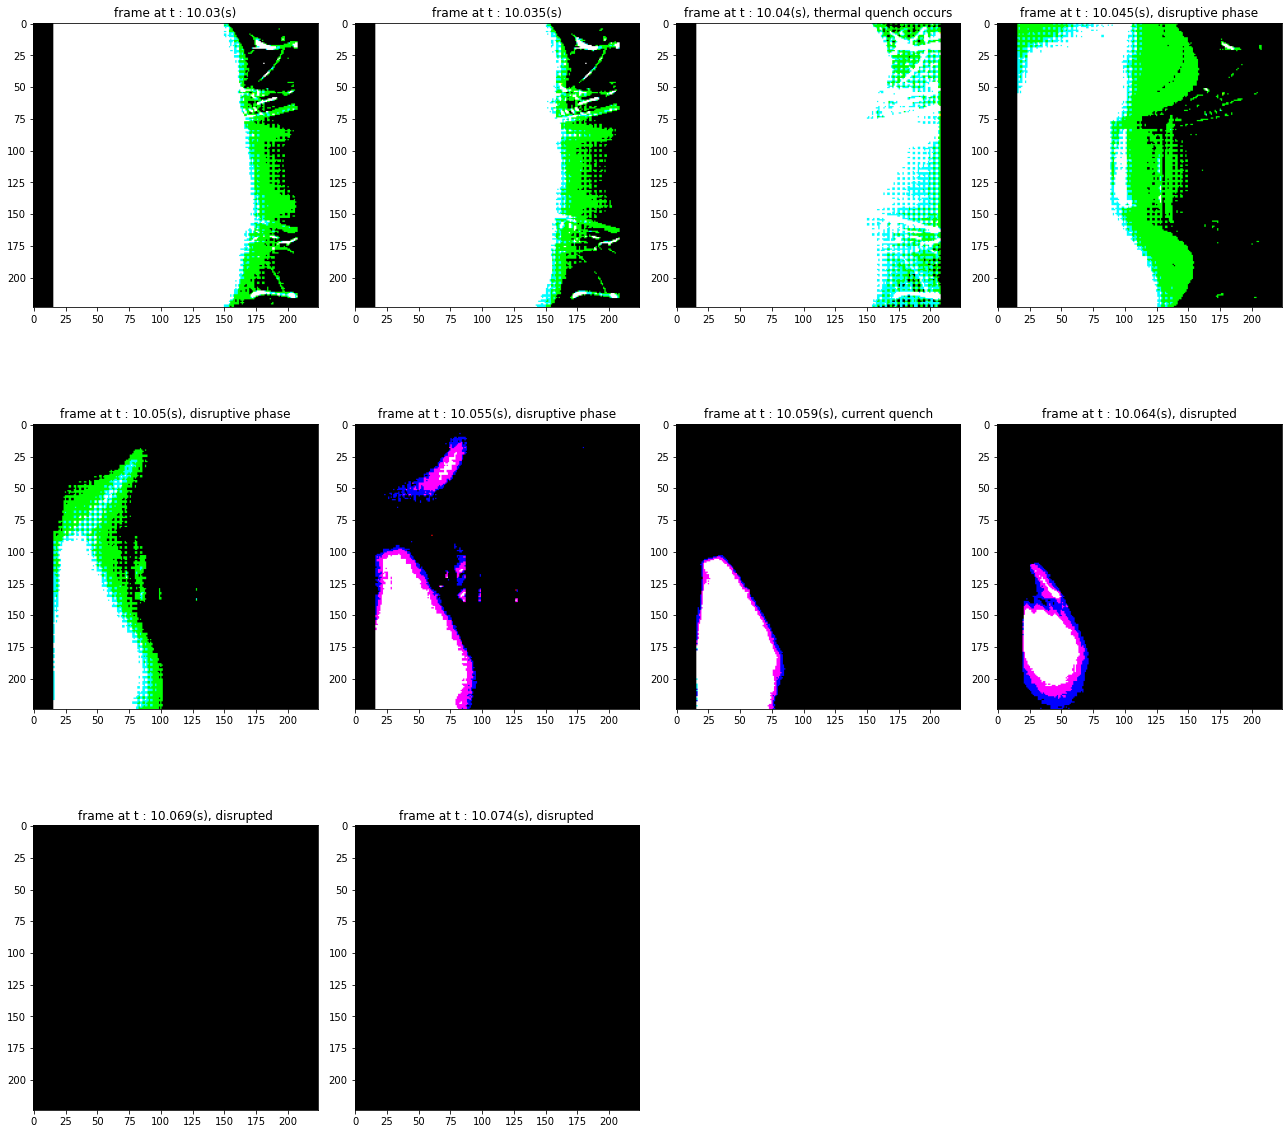

In [24]:
# example
from src.visualization.visualize_video import show_all_frame
shot_num = 21274

show_all_frame(
    shot_number = shot_num,
    t_start = 10.03, 
    t_end = 10.078, 
    t_interval = 1.0 / 210,
)

In [9]:
kstar_shot_df[kstar_shot_df.shot == 21747]

,shot,year,tftsrt,tipminf,tTQend,Isdata
1094,21747,2018,3.724,11.451,11.419,NaN


In [23]:
(13.261 - 0.1) * 210

2763.81

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

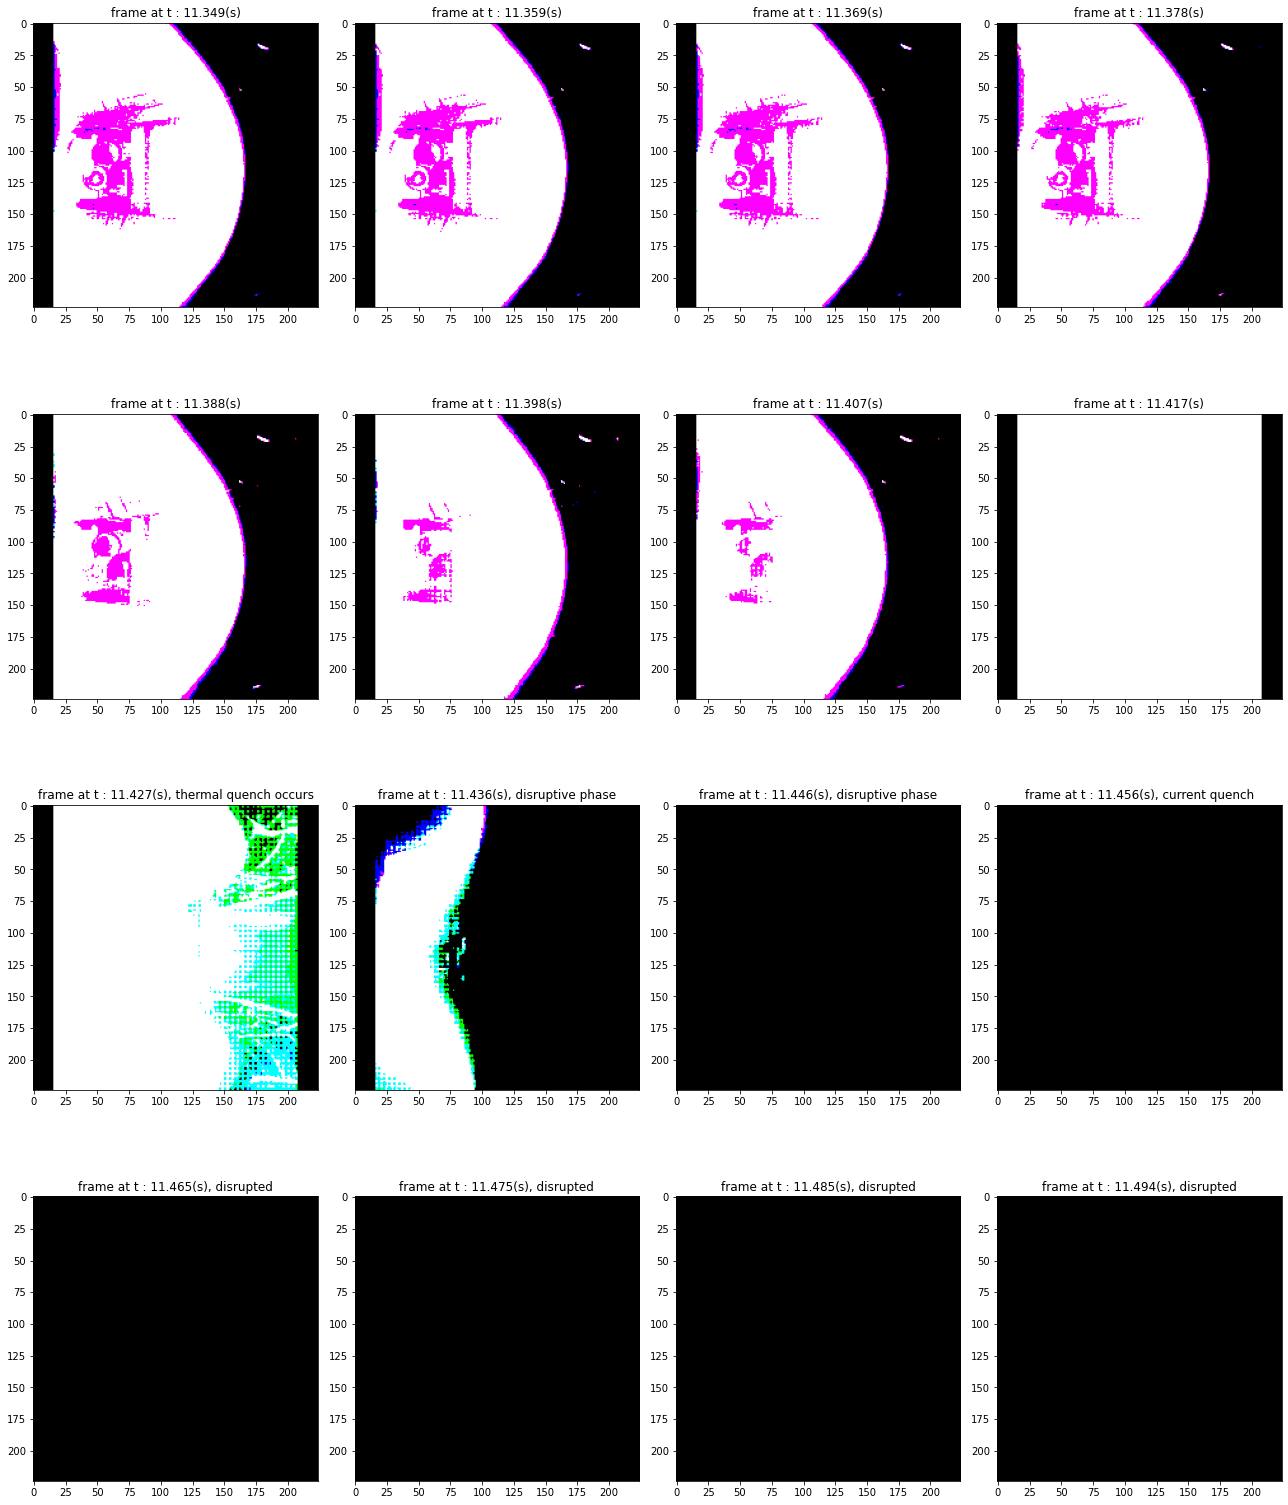

In [13]:
from src.visualization.visualize_video import show_all_frame

shot_number = 21747

show_all_frame(
    shot_number = shot_number,
    t_start = 11.35, 
    t_end = 11.5, 
    t_interval = 2.0 / 210,
)

In [10]:
kstar_shot_df[kstar_shot_df.shot == 21731]

,shot,year,tftsrt,tipminf,tTQend,Isdata
1092,21731,2018,1.5,4.913,4.895,NaN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


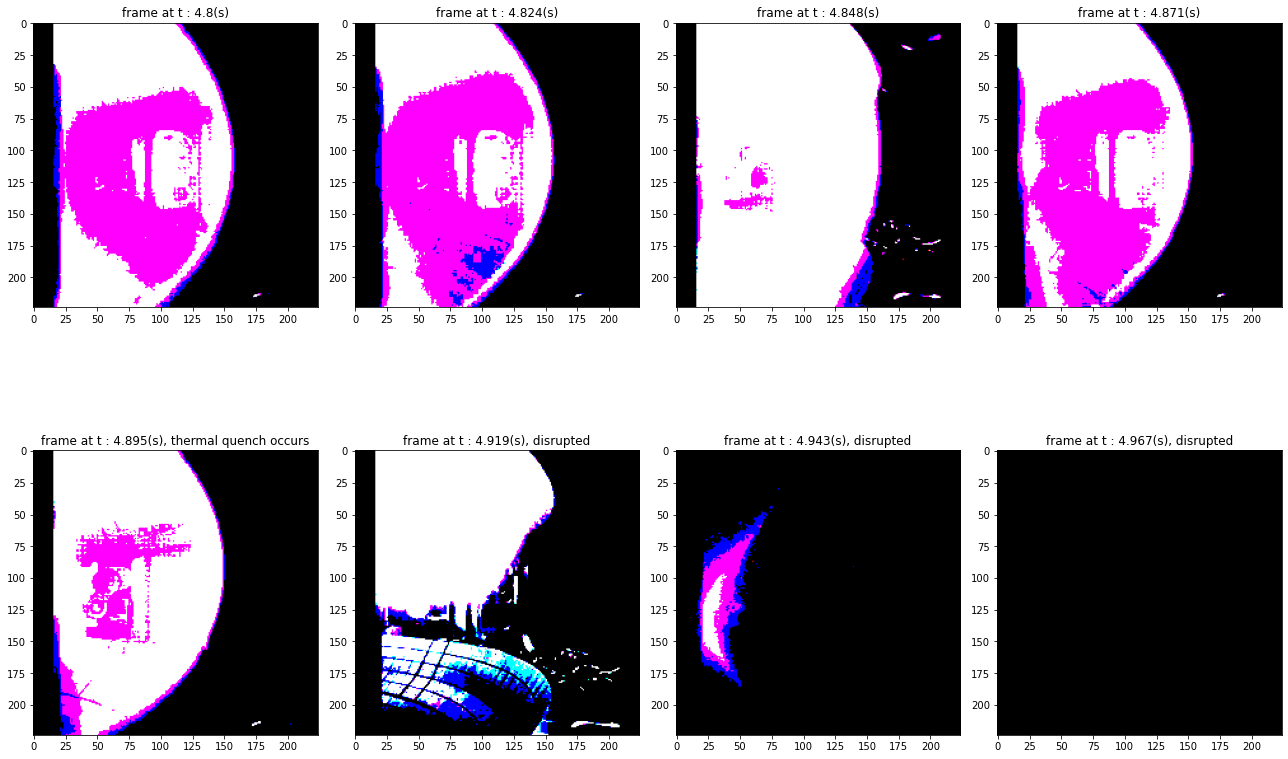

In [11]:
shot_number = 21731
show_all_frame(
    shot_number = shot_number,
    t_start = 4.8, 
    t_end = None, 
    t_interval = 1.0 / 210 * 5,
)

In [19]:
num = 0
for shot in video_shot_list:
    if kstar_shot_df[kstar_shot_df.shot == shot]['tTQend'].values[0] < 10 and kstar_shot_df[kstar_shot_df.shot == shot]['tTQend'].values[0] > 4: 
        num += 1

print(num)

51


In [ ]:
import glob2
import numpy as np
shot_list = glob2.glob("./dataset/raw_videos/raw_videos/*.avi")
shot_list = [x.split("/")[-1] for x in shot_list]
shot_num_list = [int(x.split("t")[0]) for x in shot_list]

shot_tv01_list = sorted([int(x.split("t")[0]) for x in shot_list if "tv01" in x])
shot_tv02_list = sorted([int(x.split("t")[0]) for x in shot_list if "tv02" in x])

print(shot_tv01_list)
print(shot_tv02_list)

In [18]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
from src.utils.utility import crop, normalize
from functools import partial
from tqdm.auto import tqdm
from multiprocessing import Pool, cpu_count
import gc
import pandas as pd

save_dir = "./results/disruption_phase"
resize_height = 196
resize_width = 196
crop_size = 128
fps = 210
eps = 1e-1
t_interval_min = 4.0 / fps

t_disrupt_list = []

if not os.path.exists(save_dir):
    os.mkdir(os.path.join(save_dir))

kstar_shot_df = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List.csv', encoding = "euc-kr")

for shot_num in tqdm(video_shot_list):
    t_tqend = kstar_shot_df[kstar_shot_df.shot == shot_num]["tTQend"].values[0]
    t_ipmin = kstar_shot_df[kstar_shot_df.shot == shot_num]["tipminf"].values[0]

    t_tqend += 0.1
    t_ipmin += 0.1

    if t_tqend > 10.0 :
        fps = 207
    else:
        fps = 210

    file_path = os.path.join(save_dir, "%06dtv01.png"%shot_num)
    video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

    if not os.path.exists(video_dir):
        file_path = os.path.join(save_dir, "%06dtv02.png"%shot_num)
        video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv02.avi"%shot_num)
        
    if not os.path.exists(video_dir):
        continue

    capture = cv2.VideoCapture(video_dir)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

    count = 0
    channels = 3
    retaining = True

    buffer = np.empty((frame_count, resize_height, resize_width, channels), np.dtype('float32'))

    while (count < frame_count and retaining):
        retaining, frame = capture.read()

        if frame is None:
            frame = np.zeros((resize_width, resize_height, channels))

        if (frame_height != resize_height) or (frame_width != resize_width):
            frame = cv2.resize(frame, (resize_width, resize_height))

        buffer[count] = frame
        count += 1

    capture.release()

    buffer = crop(buffer, resize_height, resize_width, crop_size)
    buffer = normalize(buffer)

    t_interval = (t_ipmin - t_tqend) / 2 if t_ipmin - t_tqend > t_interval_min * 2 else t_interval_min
    t_start = t_tqend - t_interval * 4
    t_end = t_tqend + t_interval * 4

    if t_end * fps > frame_count:
        t_end = (frame_count-1) / fps

    show_indices = range(round(t_start * fps), round(t_end * fps), round(t_interval * fps))

    if frame_count < t_start * fps:
        t_disrupt = 0
        t_disrupt_list.append(t_disrupt)
        del buffer
        del capture
        continue

    # plot the image with (4 X N) array
    fig_width = 18
    fig_height = 0
    fig_cols = 4
    fig_rows = 2

    if len(show_indices) % fig_cols > 0:
        fig_rows += 1

    fig_height = int(fig_rows * 4.5) + 4

    axes=[]
    fig = plt.figure(figsize = (fig_width, fig_height), facecolor = 'white')

    is_tq = False
    is_iq = False
    is_cutoff = False
    t_disrupt = 0

    for idx in range(len(show_indices)):
        frame_idx = int(show_indices[idx])
        frame = buffer[frame_idx, :, :, :]
        t = frame_idx / fps
        axes.append(fig.add_subplot(fig_rows, fig_cols, idx+1))

        if eps * frame.shape[0] * frame.shape[1] * frame.shape[2] > np.sum(frame) and not is_cutoff:
            t_disrupt = t
            is_cutoff = True

        if t_tqend is not None and t >= t_tqend and not is_tq:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), thermal quench"
            is_tq = True
        elif t >= t_tqend and t < t_ipmin:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), disruptive phase"
        elif t >= t_ipmin and not is_iq:
            is_iq = True
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), current quench"
        elif not is_tq:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s)"
        elif is_iq and is_tq:
            subplot_title = "frame at t : " + str(round(t,3)) + "(s), disrupted"

        axes[-1].set_title(subplot_title)  
        plt.imshow(frame)

    t_disrupt_list.append(t_disrupt)

    fig.tight_layout()    
    plt.savefig(file_path, facecolor = fig.get_facecolor(), edgecolor = 'none', transparent = False)
    plt.close()

    del buffer
    del capture
    del fig

    gc.collect()

NameError: name 'video_shot_list' is not defined

In [17]:
t_tqend_list = []
t_ipmin_list = []
t_tftsrt_list = []
year_list = []

for shot in video_shot_list:
    t_tftsrt_list.append(kstar_shot_df[kstar_shot_df.shot == shot]['tftsrt'].values[0])
    t_tqend_list.append(kstar_shot_df[kstar_shot_df.shot == shot]['tTQend'].values[0])
    t_ipmin_list.append(kstar_shot_df[kstar_shot_df.shot == shot]['tipminf'].values[0])
    year_list.append(kstar_shot_df[kstar_shot_df.shot == shot]['year'].values[0])
    
new_shot_df = pd.DataFrame(
    {
        "shot" : video_shot_list,
        "year" : year_list,
        "tftsrt" : t_tftsrt_list,
        "tipminf" : t_ipmin_list,
        "tTQend":t_tqend_list,
        "tCutOff" : t_disrupt_list
    }
)

In [18]:
new_shot_df.to_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv", index = False)

In [19]:
new_shot_df = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv").reset_index(drop = True)

In [20]:
new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,tCutOff
0,21273,2018,2.996,5.535,5.514,5.557143
1,21274,2018,2.996,10.056,10.038,10.062802
2,21310,2018,1.500,5.368,5.342,5.385714
3,21315,2018,1.500,7.804,7.782,7.804762
4,21317,2018,1.500,9.460,9.438,9.461905


In [45]:
post_quench_list = new_shot_df[new_shot_df.tCutOff < new_shot_df.tTQend]
pre_quench_list = new_shot_df[new_shot_df.tCutOff > new_shot_df.tTQend]

In [49]:
pre_quench_list.head()

,shot,year,tftsrt,tipminf,tTQend,tCutOff
0,21273,2018,2.996,5.535,5.514,5.557143
1,21274,2018,2.996,10.056,10.038,10.062802
2,21310,2018,1.500,5.368,5.342,5.385714
3,21315,2018,1.500,7.804,7.782,7.804762
4,21317,2018,1.500,9.460,9.438,9.461905


In [46]:
post_quench_list.head()

,shot,year,tftsrt,tipminf,tTQend,tCutOff


In [47]:
post_quench_list['tTQend'] = post_quench_list['tTQend'].apply(lambda x : x * 207 / 210 - 0.1)
post_quench_list['tipminf'] = post_quench_list['tipminf'].apply(lambda x : x* 207 / 210 - 0.1)

In [48]:
post_quench_list.head()

,shot,year,tftsrt,tipminf,tTQend,tCutOff


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

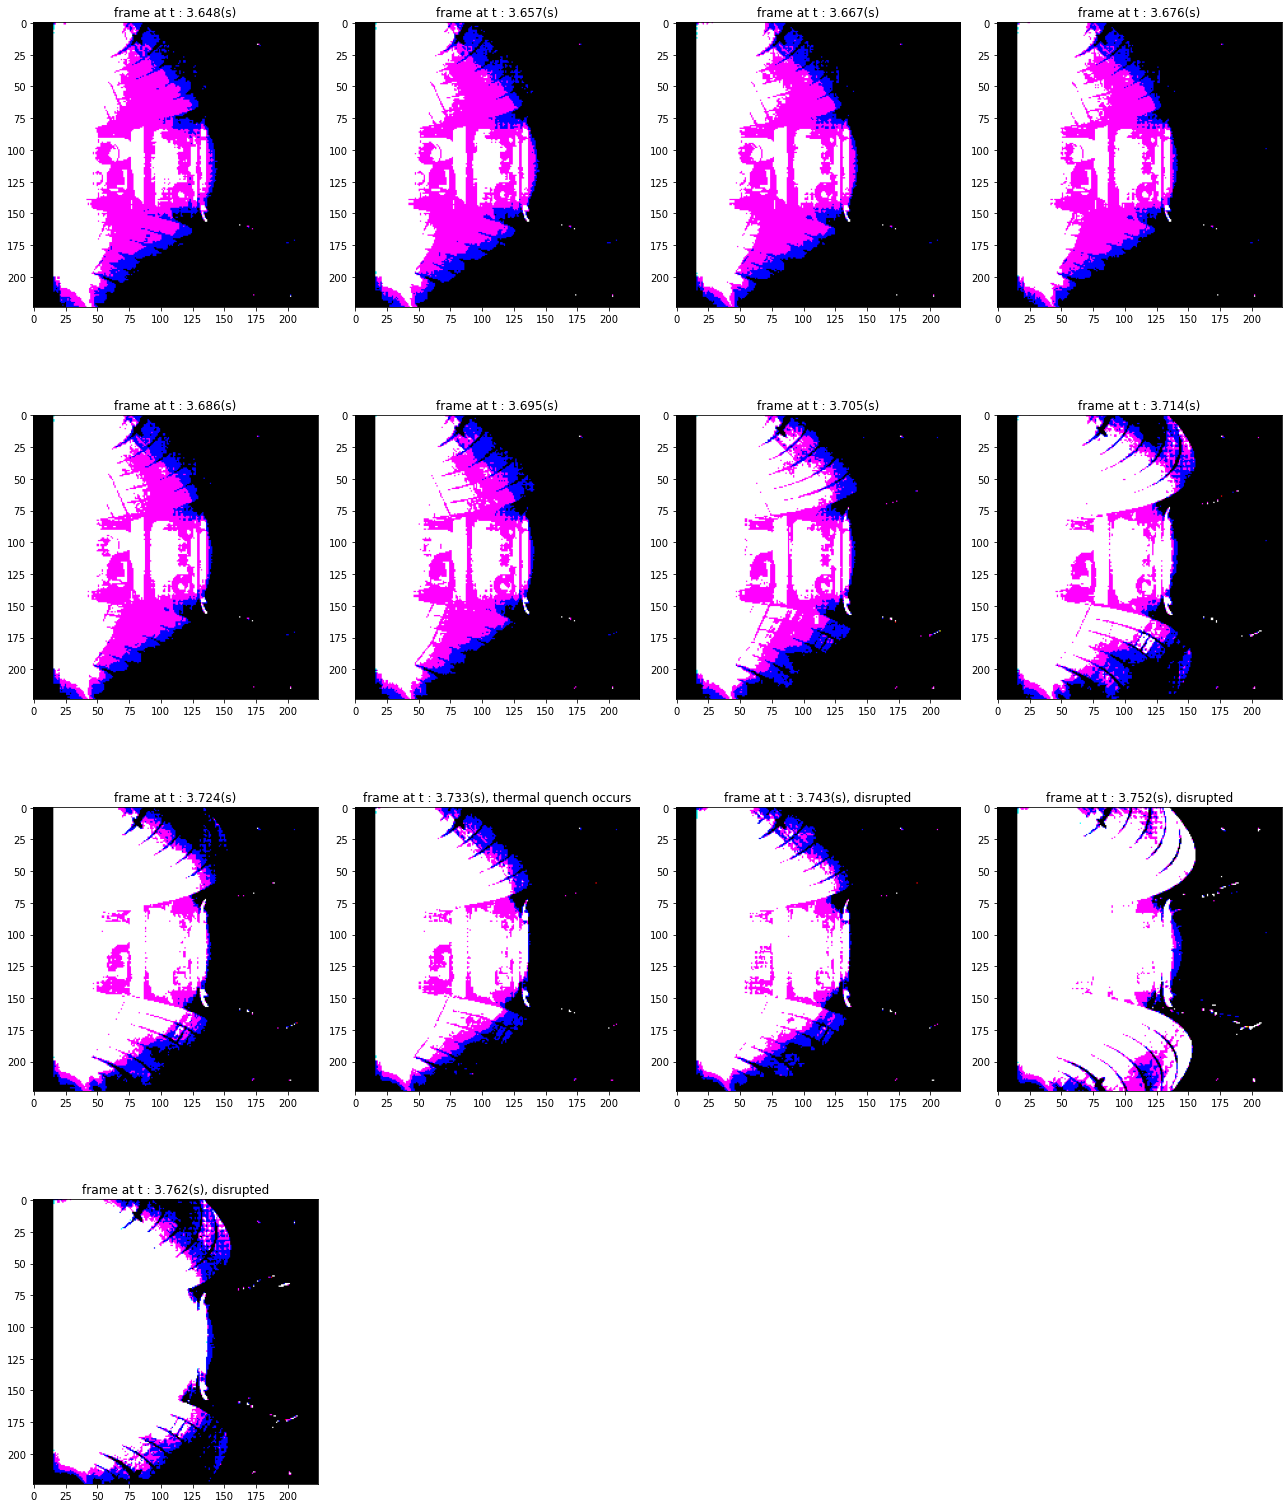

In [59]:
shot_number = 21630
show_all_frame(
    shot_number=shot_number,
    t_start = 3.65,
    t_interval=2.0 / fps
)

In [19]:
pre_quench_list

,shot,year,tftsrt,tipminf,tTQend,tCutOff
0,21273,2018,2.996,5.535,5.514,5.571429
1,21274,2018,2.996,10.056,10.038,10.095238
2,21310,2018,1.500,5.368,5.342,5.400000
3,21315,2018,1.500,7.804,7.782,7.838095
4,21317,2018,1.500,9.460,9.438,9.495238
...,...,...,...,...,...,...
75,21683,2018,5.500,8.657,8.617,8.690476
77,21730,2018,1.500,4.968,4.949,5.004762
78,21731,2018,1.500,4.913,4.895,4.952381
79,21735,2018,1.500,89.746,89.732,89.790476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

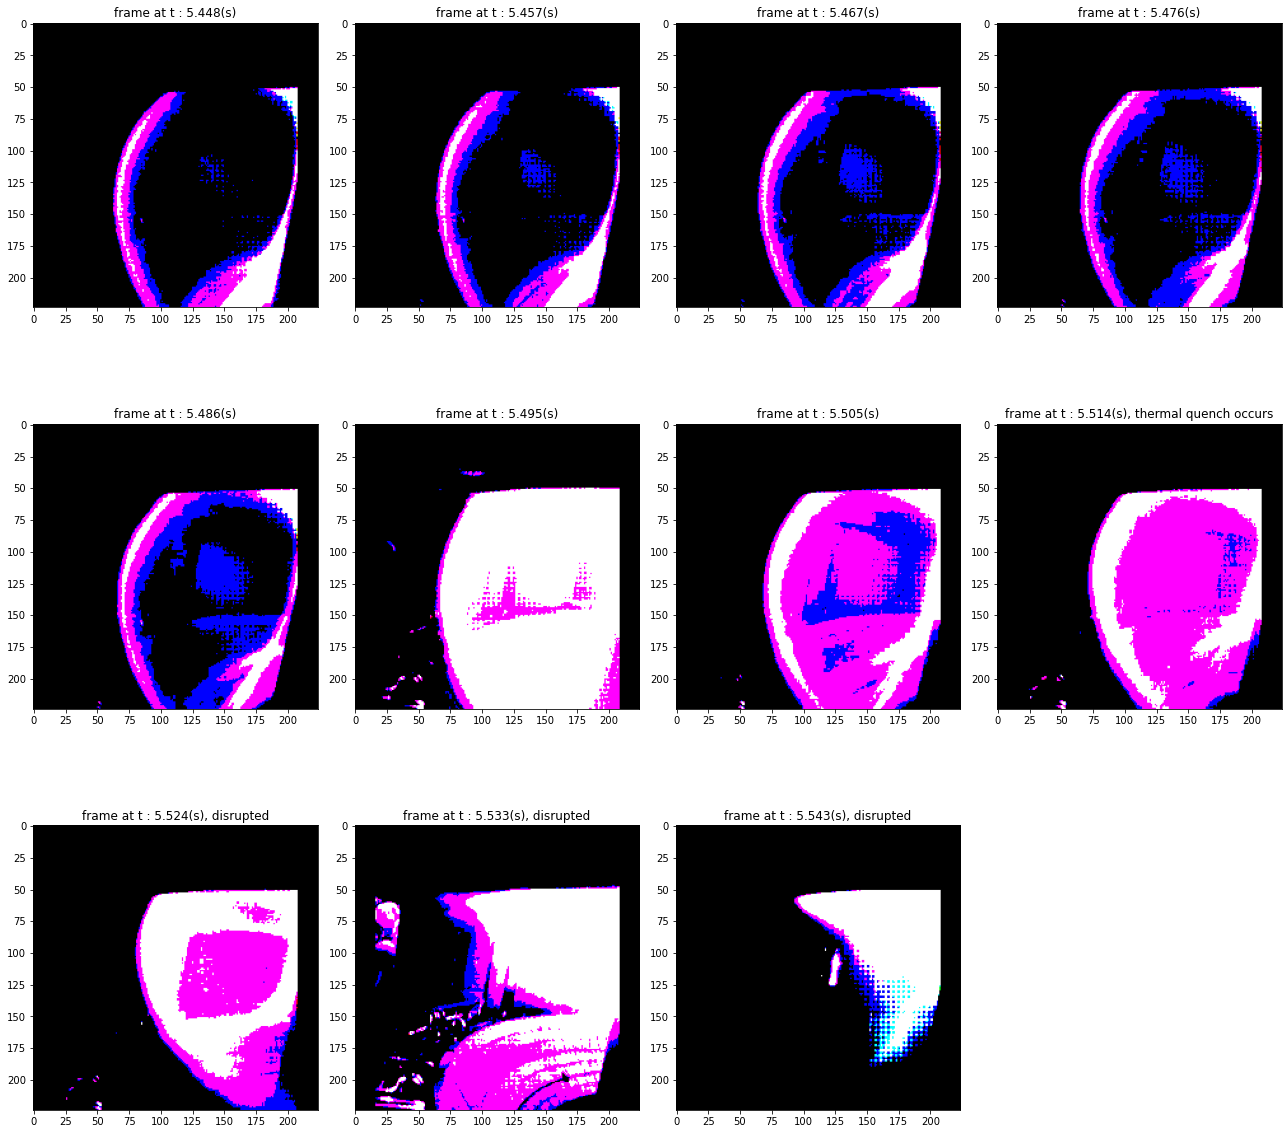

In [40]:
shot_number = 21273
fps = 210
show_all_frame(
    shot_number=shot_number,
    t_start = 5.45,
    t_interval=2.0 / fps
)

In [21]:
new_shot_df[new_shot_df.shot == 21747]

,shot,year,tftsrt,tipminf,tTQend,tCutOff
80,21747,2018,3.724,11.451,11.419,11.47619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


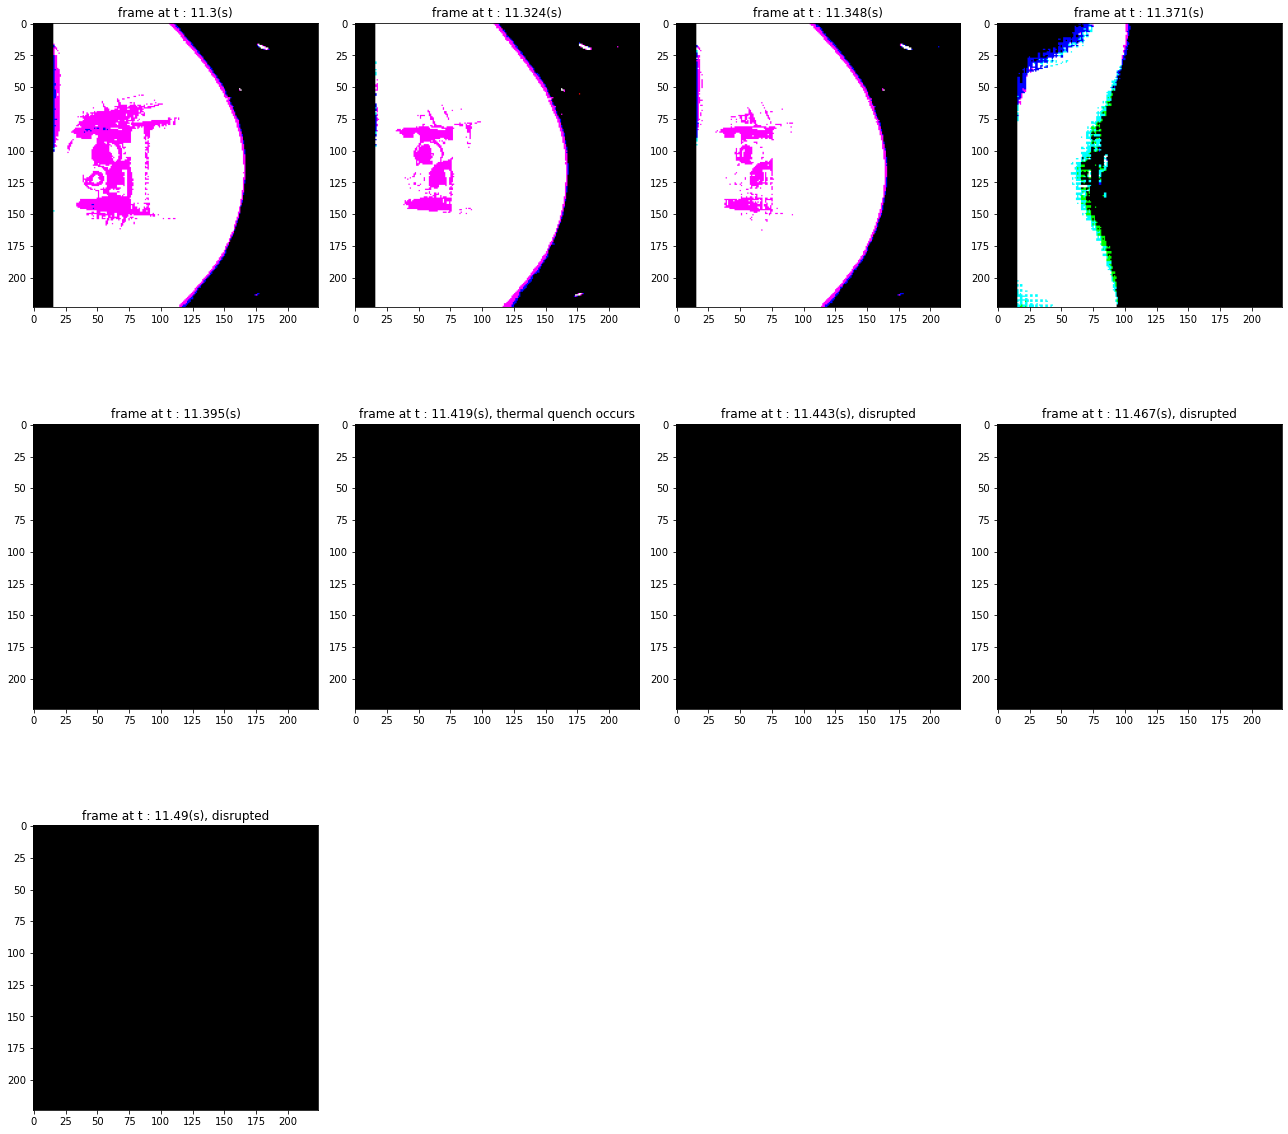

In [22]:
shot_number = 21747
show_all_frame(
    shot_number=shot_number,
    t_start = 11.3,
    t_interval=5.0 / fps
)